# Load Libraries

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import vis
from model.bayesObs import BayesianObserver
from model.oldBayesObs import OldBayesianObserver
from scipy.stats import pearsonr
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from funcs.pixTrans import pix2ang
from funcs.modelComp import AICMet, BICMet

# Load Data

In [77]:
# Get Subject Name

figPath      = r'F:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\Results\Figures'
subjectsPath = r'F:\#2 MS Projects\Ongoing\timePerception\analysis\Data'
subInfoPath  = r'F:\#2 MS Projects\Ongoing\timePerception\dataInfo\input'
subjectNames = os.listdir(subjectsPath) 

print(f"[0]: Average Over All Subjects")
for iterator, name in enumerate(subjectNames):
    print(f"[{iterator + 1}]: {name}")

idx = input()
if (idx != '0'):
    subjectName = subjectNames[int(idx) - 1]
else:
    subjectName = 'All'

# Load Data

exclude = ['KiomarsSharifi']
if (subjectName == 'All'):
    tmpTime  = []
    tmpSpace = []  
    for iterator, name in enumerate(subjectNames):
        if (name in exclude):
            continue
        if (os.path.isfile(os.path.join(subjectsPath, name, name+'_timeData.csv'))):
            timeTable  = pd.read_csv(os.path.join(subjectsPath, name, name+'_timeData.csv'))
            tmpTime.append(timeTable)
        if (os.path.isfile(os.path.join(subjectsPath, name, name+'_spaceData.csv'))):
            spaceTable = pd.read_csv(os.path.join(subjectsPath, name, name+'_spaceData.csv'))
            tmpSpace.append(spaceTable)
    timeTable  = pd.concat(tmpTime, axis=0, ignore_index=True)
    spaceTable = pd.concat(tmpSpace, axis=0, ignore_index=True)
else: 
    subjectDataPath = os.path.join(subjectsPath, subjectName)
    timeTable       = pd.read_csv(os.path.join(subjectDataPath, subjectName+'_timeData.csv'))
    spaceTable      = pd.read_csv(os.path.join(subjectDataPath, subjectName+'_spaceData.csv'))
 
print(f"\nFilter?\nYes: 1")
filter = input()

# Make Directory

subjectFigPath = os.path.join(figPath, subjectName)
if not os.path.exists(subjectFigPath):
    os.mkdir(subjectFigPath)

# Transform Distances

spaceTable['prodDist_1'] = spaceTable['prodDist_1'].apply(lambda x: pix2ang(x, 600, 0.276))

[0]: Average Over All Subjects
[1]: AliHajian
[2]: KiomarsSharifi
[3]: MehdiSanayei
[4]: MiladYekani
[5]: MobinAdli
[6]: MobinaKhosravi
[7]: ParisaShadmehr
[8]: SepehrSima
[9]: SoodehMajidpour

Filter?
Yes: 1


## Trim Data

In [78]:
Q1Time  = timeTable['RT'].quantile(.25)
Q3Time  = timeTable['RT'].quantile(.75)
IQRTime = Q3Time - Q1Time

Q1Space  = spaceTable['prodDist_1'].quantile(.25)
Q3Space  = spaceTable['prodDist_1'].quantile(.75)
IQRSpace = Q3Space - Q1Space

if (filter == '1'):
    timeTable = timeTable.query('(@Q1Time - 1.5 * @IQRTime) <= RT <= (@Q3Time + 1.5 * @IQRTime)')
    spaceTable = spaceTable.query('(@Q1Space - 1.5 * @IQRSpace) <= prodDist_1 <= (@Q3Space + 1.5 * @IQRSpace)')
    spaceTable = spaceTable.query('RT > .2')

## Define Inputs

In [79]:
initlValuesTwo  = np.array([0.3, 0.3])
initlValuesThr  = np.array([0.3, 0.3, 0.8])
integSteps      = 1000
timeIntegRange  = [0.001, 10]
spaceIntegRange = [0.001, 20]
estimType       = ['BLS', 'MLE']

tSvec           = np.array(timeTable['timeInterval'])
tPvec           = np.array(timeTable['RT'])
minTimeR        = np.min(timeTable['timeInterval'])
maxTimeR        = np.max(timeTable['timeInterval'])

groupTime       = timeTable.groupby(['timeIntervalType']).RT.apply(list)
groupTime       = [np.array(groupTime[2]), np.array(groupTime[0]), np.array(groupTime[1])]
timeInts        = np.unique(timeTable['timeInterval'])

dSvec           = np.array(spaceTable['distInterval'])
dPvec           = np.array(spaceTable['prodDist_1'])
minSpaceR       = np.min(spaceTable['distInterval'])
maxSpaceR       = np.max(spaceTable['distInterval'])

groupSpace      = spaceTable.groupby("distIntervalType")["prodDist_1"].apply(list)
groupSpace      = [np.array(groupSpace[2]), np.array(groupSpace[0]), np.array(groupSpace[1])]
distInts        = np.unique(spaceTable['distInterval'])

## Load Subjects' Information

In [80]:
subInfoInput = pd.read_csv(os.path.join(subInfoPath, 'subInfo.csv'))
subInfoInput

,name,ID,age,gender,handedness,firstBlocks,lineLoc,lineOr,AIC_BLS_Space,AIC_BLS_Space_Mod,AIC_MLE_Space,AIC_MLE_Space_Mod,AIC_BLS_Time,AIC_BLS_Time_Mod,AIC_MLE_Time,AIC_MLE_Time_Mod,BIC_BLS_Space,BIC_BLS_Space_Mod,BIC_MLE_Space,BIC_MLE_Space_Mod,BIC_BLS_Time,BIC_BLS_Time_Mod,BIC_MLE_Time,BIC_MLE_Time_Mod,timeWm_BLS,timeWm_BLS_Mod,timeWm_MLE,timeWm_MLE_Mod,timeWp_BLS,timeWp_BLS_Mod,timeWp_MLE,timeWp_MLE_Mod,spaceWm_BLS,spaceWm_BLS_Mod,spaceWm_MLE,spaceWm_MLE_Mod,spaceWp_BLS,spaceWp_BLS_Mod,spaceWp_MLE,spaceWp_MLE_Mod,timeAlpha_BLS,spaceAlpha_BLS,timeAlpha_MLE,spaceAlpha_MLE
0,SepehrSima,1,23,M,R,time,right,up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MehdiSanayei,2,40,M,R,space,left,up,1787.866386,1769.858408,1779.176804,1758.691319,65.202291,44.338191,280.268600,250.265825,1795.893816,1781.899554,1787.204234,1770.732465,73.229722,56.379337,288.296031,262.306971,0.250836,0.282251,0.196456,0.274042,0.270235,0.272552,0.363986,0.274061,0.025980,0.02598,0.027337,0.22165,0.255606,0.236263,0.251881,0.073932,0.919720,1.055940,1.137640,1.10545
2,KiomarsSharifi,3,28,M,R,time,right,up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MobinAdli,4,23,M,R,space,right,up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AliHajian,5,21,M,L,time,left,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MiladYekani,6,35,M,R,space,left,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MobinaKhosravi,7,21,F,R,time,right,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SoodehMajidpour,8,34,F,R,space,right,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ParisaShadmehr,9,23,F,R,time,left,up,1737.312500,1700.826537,1715.193100,1715.767673,558.630872,470.382431,587.795848,597.841063,1745.290423,1712.793421,1723.171023,1727.734557,566.573395,482.296216,595.738372,609.754848,0.360139,0.291392,0.002868,0.317596,0.488282,0.361883,0.864751,0.317566,0.053151,0.06999,0.255676,0.25247,0.252421,0.257565,0.078040,0.085320,1.262824,0.921254,1.614151,0.98418


# Modeling for Time Estimation

In [9]:
simTime_BLS_Mod

[array([0.41707315, 0.27166851, 0.69338826, ..., 0.3218432 , 0.65578877,
        0.9120199 ]),
 array([1.21517524, 0.74485155, 0.47177736, ..., 0.95280032, 0.64511683,
        0.84336916]),
 array([1.49006557, 1.40950075, 1.15643925, ..., 1.16920154, 0.90955765,
        0.82028467])]

In [81]:
# Fit Three Paramters

for timeEstim in estimType:
    bnds   = ((0.0001, None), (0.0001, None), (0.0001, None))
    model  = BayesianObserver(tSvec, tPvec, minTimeR, maxTimeR, integSteps, timeIntegRange, timeEstim)
    res    = minimize(model.BayesianModel, initlValuesThr, bounds=bnds,
                      method='Nelder-Mead', options={'gtol': 1e-6, 'disp': True})
    if timeEstim == 'BLS':
        timeNLL_BLS_Mod = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mTime_BLS_Mod = res.x[0]
        w_pTime_BLS_Mod = res.x[1]
        facTime_BLS_Mod = res.x[2]
    elif timeEstim == 'MLE':
        timeNLL_MLE_Mod = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mTime_MLE_Mod = res.x[0]
        w_pTime_MLE_Mod = res.x[1]    
        facTime_MLE_Mod = res.x[2]

# Fit Two Paramters

for timeEstim in estimType:
    bnds   = ((0.0001, None), (0.0001, None))
    model  = OldBayesianObserver(tSvec, tPvec, minTimeR, maxTimeR, integSteps, timeIntegRange, timeEstim)
    res    = minimize(model.BayesianModel, initlValuesTwo, bounds=bnds,
                      method='Nelder-Mead', options={'gtol': 1e-6, 'disp': True})
    if timeEstim == 'BLS':
        timeNLL_BLS = model.BayesianModel([res.x[0], res.x[1]])
        w_mTime_BLS = res.x[0]
        w_pTime_BLS = res.x[1]
    elif timeEstim == 'MLE':
        timeNLL_MLE = model.BayesianModel([res.x[0], res.x[1]])
        w_mTime_MLE = res.x[0]
        w_pTime_MLE = res.x[1]    

# Simulate Three Parameters

for timeEstim in estimType:
    model  = BayesianObserver(tSvec, tPvec, minTimeR, maxTimeR, integSteps, timeIntegRange, timeEstim)
    if timeEstim == 'BLS':
        tmpTime_BLS_Mod = [w_mTime_BLS_Mod, w_pTime_BLS_Mod, facTime_BLS_Mod]
        simTime_BLS_Mod = model.BayesSimulation(tmpTime_BLS_Mod, 20)
    elif timeEstim == 'MLE':
        tmpTime_MLE_Mod = [w_mTime_MLE_Mod, w_pTime_MLE_Mod, facTime_MLE_Mod]
        simTime_MLE_Mod = model.BayesSimulation(tmpTime_MLE_Mod, 20)

simTime_BLS_Mod     = [simTime_BLS_Mod[1][np.where(simTime_BLS_Mod[0] == num)[0]] for num in np.unique(simTime_BLS_Mod[0])]
muTimeTrans_BLS_Mod = [np.mean(x) for x in simTime_BLS_Mod]
siTimeTrans_BLS_Mod = [np.std(x) for x in simTime_BLS_Mod]

simTime_MLE_Mod     = [simTime_MLE_Mod[1][np.where(simTime_MLE_Mod[0] == num)[0]] for num in np.unique(simTime_MLE_Mod[0])]
muTimeTrans_MLE_Mod = [np.mean(x) for x in simTime_MLE_Mod]
siTimeTrans_MLE_Mod = [np.std(x) for x in simTime_MLE_Mod]

# Simulate Two Parameters

for timeEstim in estimType:
    model  = OldBayesianObserver(tSvec, tPvec, minTimeR, maxTimeR, integSteps, timeIntegRange, timeEstim)
    if timeEstim == 'BLS':
        tmpTime_BLS = [w_mTime_BLS, w_pTime_BLS]
        simTime_BLS = model.BayesSimulation(tmpTime_BLS, 100)
    elif timeEstim == 'MLE':
        tmpTime_MLE = [w_mTime_MLE, w_pTime_MLE]
        simTime_MLE = model.BayesSimulation(tmpTime_MLE, 100)

simTime_BLS      = [simTime_BLS[1][np.where(simTime_BLS[0] == num)[0]] for num in np.unique(simTime_BLS[0])]
muTimeTrans_BLS  = [np.mean(x) for x in simTime_BLS]
siTimeTrans_BLS  = [np.std(x) for x in simTime_BLS]

simTime_MLE      = [simTime_MLE[1][np.where(simTime_MLE[0] == num)[0]] for num in np.unique(simTime_MLE[0])]
muTimeTrans_MLE  = [np.mean(x) for x in simTime_MLE]
siTimeTrans_MLE  = [np.std(x) for x in simTime_MLE]

C:\Users\sepeh\AppData\Local\Temp\ipykernel_2468\960900921.py:6: OptimizeWarning: Unknown solver options: gtol
  res    = minimize(model.BayesianModel, initlValuesThr, bounds=bnds,


Optimization terminated successfully.
         Current function value: 843.471905
         Iterations: 51
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 1400.440979
         Iterations: 63
         Function evaluations: 114


C:\Users\sepeh\AppData\Local\Temp\ipykernel_2468\960900921.py:24: OptimizeWarning: Unknown solver options: gtol
  res    = minimize(model.BayesianModel, initlValuesTwo, bounds=bnds,


Optimization terminated successfully.
         Current function value: 852.861850
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 1761.144266
         Iterations: 35
         Function evaluations: 66


# Modeling for Distance Estimation

In [82]:
# Fit Three Paramters

for spaceEstim in estimType:
    bnds   = ((0.0001, None), (0.0001, None), (0.0001, None))
    model  = BayesianObserver(dSvec, dPvec, minSpaceR, maxSpaceR, integSteps, spaceIntegRange, spaceEstim)
    res    = minimize(model.BayesianModel, initlValuesThr, bounds=bnds,
                      method='Nelder-Mead', options={'gtol': 1e-6, 'disp': True})
    if spaceEstim == 'BLS':
        spaceNLL_BLS_Mod = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mSpace_BLS_Mod = res.x[0]
        w_pSpace_BLS_Mod = res.x[1]
        facSpace_BLS_Mod = res.x[2]
    elif spaceEstim == 'MLE':
        spaceNLL_MLE_Mod = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mSpace_MLE_Mod = res.x[0]
        w_pSpace_MLE_Mod = res.x[1]    
        facSpace_MLE_Mod = res.x[2]

# Fit Two Paramters

for spaceEstim in estimType:
    bnds   = ((0.0001, None), (0.0001, None))
    model  = OldBayesianObserver(dSvec, dPvec, minSpaceR, maxSpaceR, integSteps, spaceIntegRange, spaceEstim)
    res    = minimize(model.BayesianModel, initlValuesTwo, bounds=bnds,
                      method='Nelder-Mead', options={'gtol': 1e-6, 'disp': True})
    if spaceEstim == 'BLS':
        spaceNLL_BLS = model.BayesianModel([res.x[0], res.x[1]])
        w_mSpace_BLS = res.x[0]
        w_pSpace_BLS = res.x[1]
    elif spaceEstim == 'MLE':
        spaceNLL_MLE = model.BayesianModel([res.x[0], res.x[1]])
        w_mSpace_MLE = res.x[0]
        w_pSpace_MLE = res.x[1]    

# Simulate Three Parameters

for spaceEstim in estimType:
    model  = BayesianObserver(dSvec, dPvec, minSpaceR, maxSpaceR, integSteps, spaceIntegRange, spaceEstim)
    if spaceEstim == 'BLS':
        tmpSpace_BLS_Mod = [w_mSpace_BLS_Mod, w_pSpace_BLS_Mod, facSpace_BLS_Mod]
        simSpace_BLS_Mod = model.BayesSimulation(tmpSpace_BLS_Mod, 100)
    elif spaceEstim == 'MLE':
        tmpSpace_MLE_Mod = [w_mSpace_MLE_Mod, w_pSpace_MLE_Mod, facSpace_MLE_Mod]
        simSpace_MLE_Mod = model.BayesSimulation(tmpSpace_MLE_Mod, 100)

simSpace_BLS_Mod     = [simSpace_BLS_Mod[1][np.where(simSpace_BLS_Mod[0] == num)[0]] for num in np.unique(simSpace_BLS_Mod[0])]
muSpaceTrans_BLS_Mod = [np.mean(x) for x in simSpace_BLS_Mod]
siSpaceTrans_BLS_Mod = [np.std(x) for x in simSpace_BLS_Mod]

simSpace_MLE_Mod     = [simSpace_MLE_Mod[1][np.where(simSpace_MLE_Mod[0] == num)[0]] for num in np.unique(simSpace_MLE_Mod[0])]
muSpaceTrans_MLE_Mod = [np.mean(x) for x in simSpace_MLE_Mod]
siSpaceTrans_MLE_Mod = [np.std(x) for x in simSpace_MLE_Mod]

# Simulate Two Parameters

for spaceEstim in estimType:
    model  = OldBayesianObserver(dSvec, dPvec, minSpaceR, maxSpaceR, integSteps, spaceIntegRange, spaceEstim)
    if spaceEstim == 'BLS':
        tmpSpace_BLS = [w_mSpace_BLS, w_pSpace_BLS]
        simSpace_BLS = model.BayesSimulation(tmpSpace_BLS, 100)
    elif spaceEstim == 'MLE':
        tmpSpace_MLE = [w_mSpace_MLE, w_pSpace_MLE]
        simSpace_MLE = model.BayesSimulation(tmpSpace_MLE, 100)

simSpace_BLS      = [simSpace_BLS[1][np.where(simSpace_BLS[0] == num)[0]] for num in np.unique(simSpace_BLS[0])]
muSpaceTrans_BLS  = [np.mean(x) for x in simSpace_BLS]
siSpaceTrans_BLS  = [np.std(x) for x in simSpace_BLS]

simSpace_MLE      = [simSpace_MLE[1][np.where(simSpace_MLE[0] == num)[0]] for num in np.unique(simSpace_MLE[0])]
muSpaceTrans_MLE  = [np.mean(x) for x in simSpace_MLE]
siSpaceTrans_MLE  = [np.std(x) for x in simSpace_MLE]

C:\Users\sepeh\AppData\Local\Temp\ipykernel_2468\683432413.py:6: OptimizeWarning: Unknown solver options: gtol
  res    = minimize(model.BayesianModel, initlValuesThr, bounds=bnds,
f:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\threeParamsModel\model\bayesObs.py:24: RuntimeWarning: invalid value encountered in divide
  return factor * num / denom
f:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\threeParamsModel\model\bayesObs.py:24: RuntimeWarning: divide by zero encountered in divide
  return factor * num / denom
c:\Users\sepeh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Optimization terminated successfully.
         Current function value: 6494.226988
         Iterations: 63
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 6488.185010
         Iterations: 52
         Function evaluations: 99


C:\Users\sepeh\AppData\Local\Temp\ipykernel_2468\683432413.py:24: OptimizeWarning: Unknown solver options: gtol
  res    = minimize(model.BayesianModel, initlValuesTwo, bounds=bnds,
f:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\threeParamsModel\model\oldBayesObs.py:24: RuntimeWarning: invalid value encountered in divide
  return num / denom
f:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\threeParamsModel\model\oldBayesObs.py:24: RuntimeWarning: divide by zero encountered in divide
  return num / denom


Optimization terminated successfully.
         Current function value: 6663.184158
         Iterations: 39
         Function evaluations: 76


f:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\threeParamsModel\model\oldBayesObs.py:47: RuntimeWarning: divide by zero encountered in log
  logLike = np.sum(np.log(np.trapz(f, d_tm, axis = 1)))


Optimization terminated successfully.
         Current function value: 6510.760841
         Iterations: 37
         Function evaluations: 70


MemoryError: Unable to allocate 2.32 GiB for an array with shape (311000, 1000) and data type float64

# Visualization

## Plot Inputs

In [84]:
# biasSpaceModel = [np.mean(abs((x - si))) for x, si in zip(simSpaceTrans_BLS, distInts)]
# biasSpaceData  = [np.mean(abs((x - si))) for x, si in zip(groupSpace, distInts)]
# varSpaceModel  = [np.sqrt(np.var(abs((x - si)))) for x, si in zip(simSpaceTrans_BLS, distInts)]
# varSpaceData   = [np.sqrt(np.var(abs((x - si)))) for x, si in zip(groupSpace, distInts)]

# biasTimeModel = [np.mean(abs((x - si))) for x, si in zip(simTime_BLS, timeInts)]
# biasTimeData  = [np.mean(abs((x - si))) for x, si in zip(groupTime, timeInts)]
# varTimeModel  = [np.sqrt(np.var(abs((x - si)))) for x, si in zip(simTime_BLS, timeInts)]
# varTimeData   = [np.sqrt(np.var(abs((x - si)))) for x, si in zip(groupTime, timeInts)]

muTime        = [np.mean(x) for x in groupTime]
siTime        = [np.std(x) for x in groupTime]
muSpace       = [np.mean(x) for x in groupSpace]
siSpace       = [np.std(x) for x in groupSpace]

timeInts      = np.unique(timeTable['timeInterval'])
distInts      = np.unique(spaceTable['distInterval'])

allCondTime   = timeTable.groupby(['timeIntervalType', 'distIntervalType']).RT.apply(np.array).reset_index()
allCondSpace  = spaceTable.groupby(['timeIntervalType', 'distIntervalType']).prodDist_1.apply(np.array).reset_index()
intervals     = np.unique(timeTable['timeIntervalType'])
desiredOrder  = [2, 0, 1]  
intervalTypes = [intervals[i] for i in desiredOrder]

## Plot Variance Vs. Bias

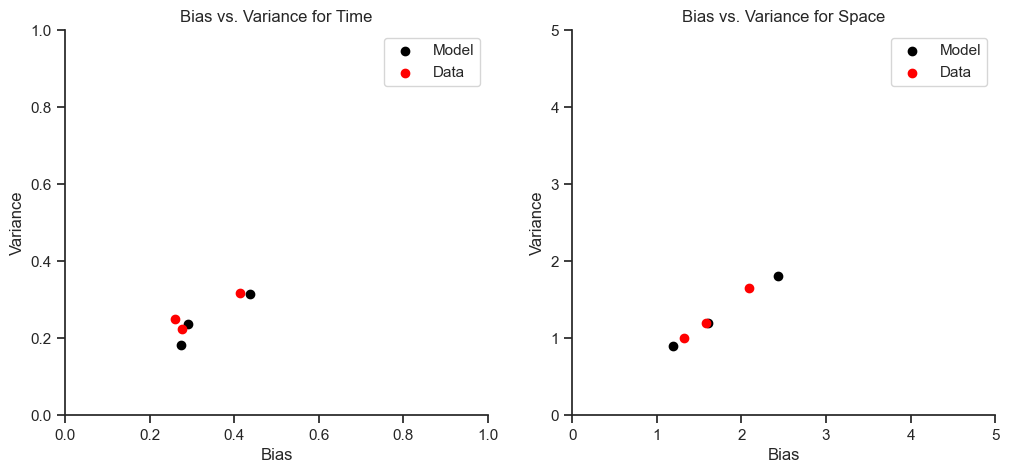

In [9]:
sns.set(style="ticks")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.despine()
vis.plotBiasVersusVariance(axs, 0, biasTimeModel, varTimeModel, biasTimeData, varTimeData, [0, 1], [0, 1], 'Time', 'black', 'red')
vis.plotBiasVersusVariance(axs, 1, biasSpaceModel, varSpaceModel, biasSpaceData, varSpaceData, [0, 5], [0, 5], 'Space', 'black', 'red')

## Plot Data Across Conditions

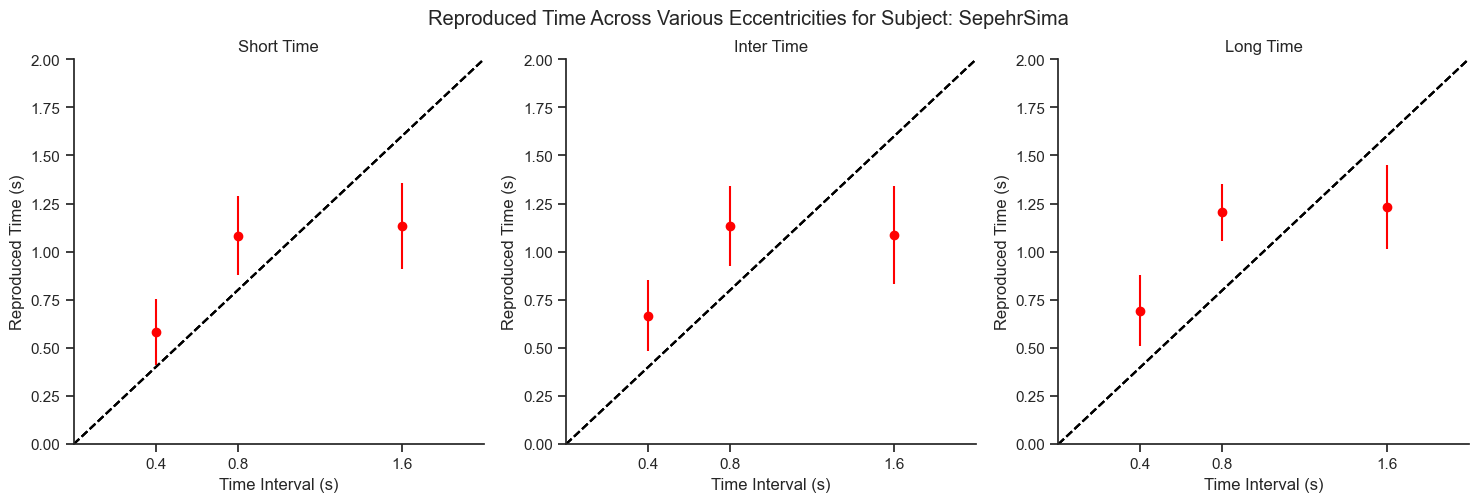

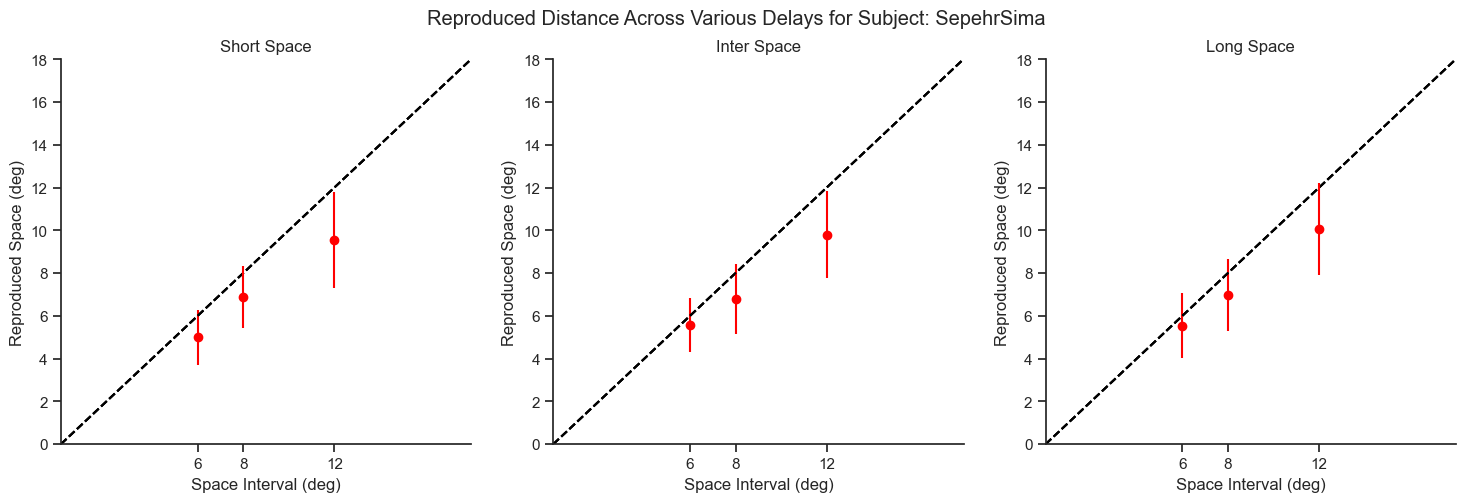

In [82]:
sns.set(style="ticks")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.despine()
vis.plotDataAcrossConds(axs, intervalTypes, timeInts, allCondTime, 'Time', 's', [0, 2], [0, 2], 'red')
fig.suptitle(f'Reproduced Time Across Various Eccentricities for Subject: {subjectName}')
fig.set_size_inches(18, 5)
plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_eccentDivided.png'), dpi=300)

sns.set(style="ticks")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.despine()
vis.plotDataAcrossConds(axs, intervalTypes, distInts, allCondSpace, 'Space', 'deg', [0, 18], [0, 18], 'red')
fig.suptitle(f'Reproduced Distance Across Various Delays for Subject: {subjectName}')
fig.set_size_inches(18, 5)
plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_delayDivided.png'), dpi=300)

# Model Stats

In [85]:
timuMuR2_BLS_Mod = r2_score(muTime, muTimeTrans_BLS_Mod)
timuMuR2_MLE_Mod = r2_score(muTime, muTimeTrans_MLE_Mod) 
timuMuR2_BLS     = r2_score(muTime, muTimeTrans_BLS)
timuMuR2_MLE     = r2_score(muTime, muTimeTrans_MLE) 

spaceMuR2_BLS_Mod = r2_score(muSpace, muSpaceTrans_BLS_Mod)
spaceMuR2_MLE_Mod = r2_score(muSpace, muSpaceTrans_MLE_Mod)
spaceMuR2_BLS     = r2_score(muSpace, muSpaceTrans_BLS)
spaceMuR2_MLE     = r2_score(muSpace, muSpaceTrans_MLE)

AICTime_BLS_Mod = AICMet(timeNLL_BLS_Mod, len(initlValuesThr))
AICTime_MLE_Mod = AICMet(timeNLL_MLE_Mod, len(initlValuesThr))
AICTime_BLS     = AICMet(timeNLL_BLS, len(initlValuesTwo))
AICTime_MLE     = AICMet(timeNLL_MLE, len(initlValuesTwo))

BICTime_BLS_Mod = BICMet(timeNLL_BLS_Mod, len(initlValuesThr), len(tPvec))
BICTime_MLE_Mod = BICMet(timeNLL_MLE_Mod, len(initlValuesThr), len(tPvec))
BICTime_BLS     = BICMet(timeNLL_BLS, len(initlValuesTwo), len(tPvec))
BICTime_MLE     = BICMet(timeNLL_MLE, len(initlValuesTwo), len(tPvec))

AICSpace_BLS_Mod = AICMet(spaceNLL_BLS_Mod, len(initlValuesThr))
AICSpace_MLE_Mod = AICMet(spaceNLL_MLE_Mod, len(initlValuesThr))
AICSpace_BLS     = AICMet(spaceNLL_BLS, len(initlValuesTwo))
AICSpace_MLE     = AICMet(spaceNLL_MLE, len(initlValuesTwo))

BICSpace_BLS_Mod = BICMet(spaceNLL_BLS_Mod, len(initlValuesThr), len(dPvec))
BICSpace_MLE_Mod = BICMet(spaceNLL_MLE_Mod, len(initlValuesThr), len(dPvec))
BICSpace_BLS     = BICMet(spaceNLL_BLS, len(initlValuesTwo), len(dPvec))
BICSpace_MLE     = BICMet(spaceNLL_MLE, len(initlValuesTwo), len(dPvec))

## Plot Simulation Data Over Real Data

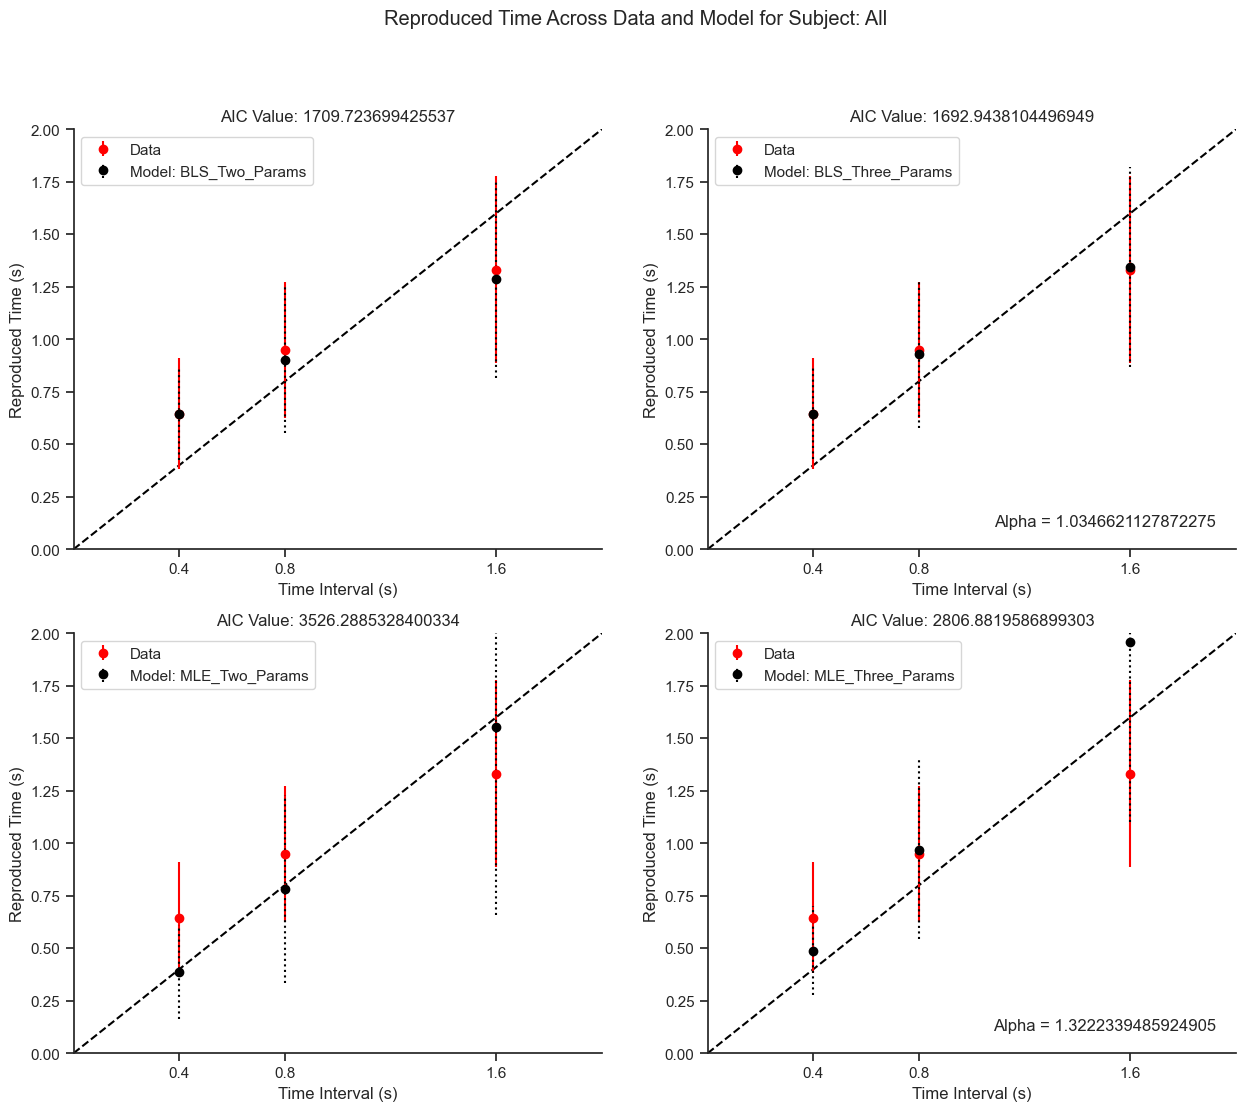

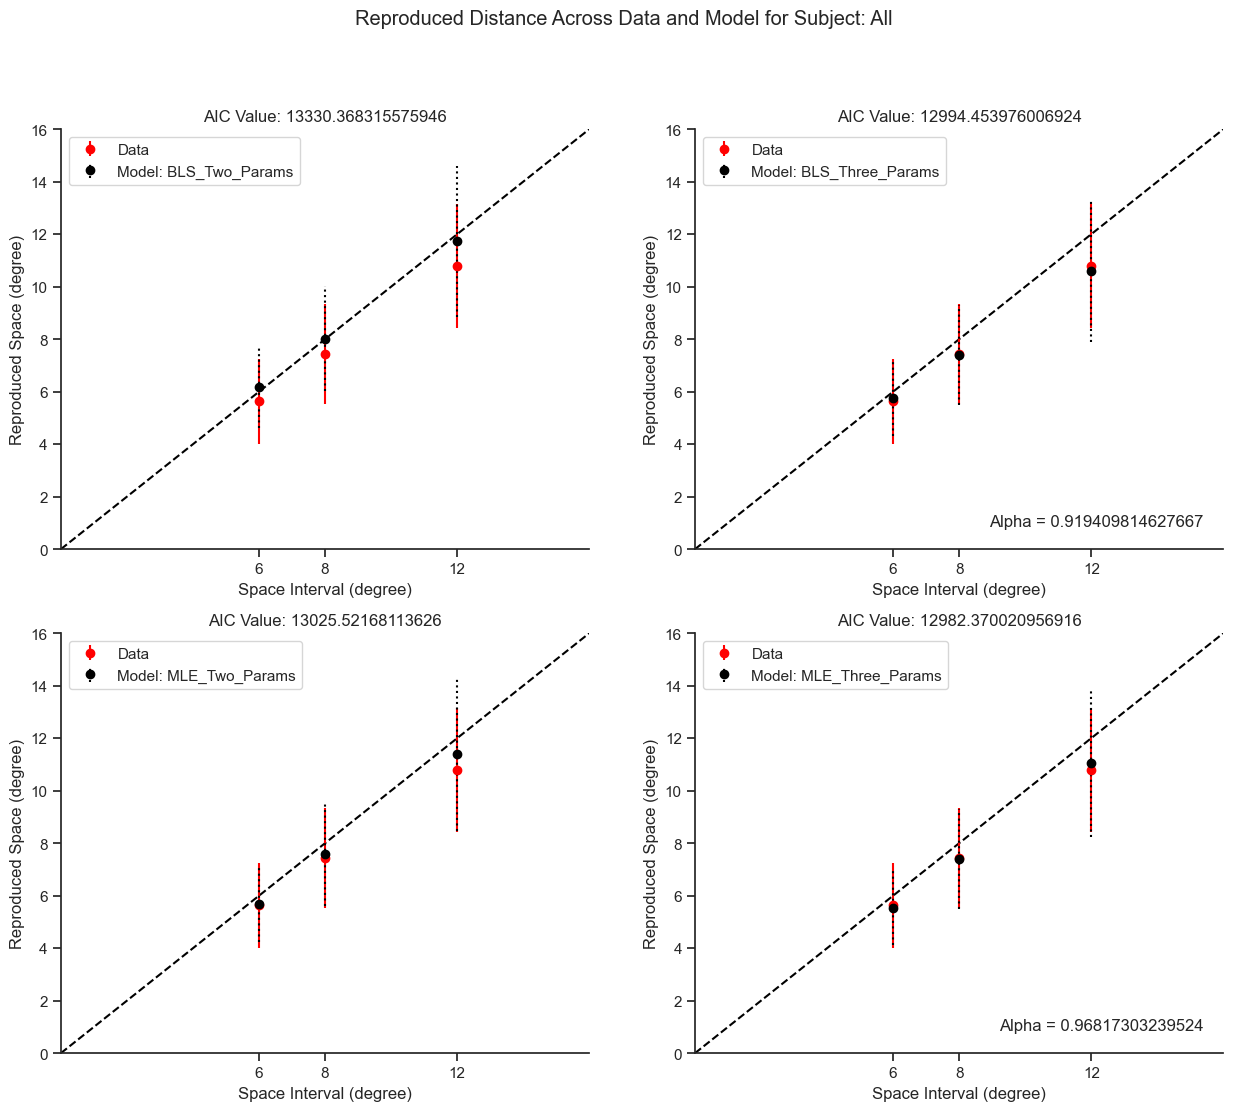

In [86]:
sns.set(style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
sns.despine()
                  
vis.plotModelOverData(axs, 0, 0, timeInts, muTime, siTime, muTimeTrans_BLS, siTimeTrans_BLS, 'Time', 's', [0, 2], [0, 2], 'red', 'black', 'BLS_Two_Params', AICTime_BLS)
vis.plotModelOverData(axs, 0, 1, timeInts, muTime, siTime, muTimeTrans_BLS_Mod, siTimeTrans_BLS_Mod, 'Time', 's', [0, 2], [0, 2], 'red', 'black', 'BLS_Three_Params', AICTime_BLS_Mod)
axs[0][1].annotate(f'Alpha = {facTime_BLS_Mod}', xy=(1, 0), xycoords='axes fraction', xytext=(-20, 20), textcoords='offset pixels', horizontalalignment='right', verticalalignment='bottom')
vis.plotModelOverData(axs, 1, 0, timeInts, muTime, siTime, muTimeTrans_MLE, siTimeTrans_MLE, 'Time', 's', [0, 2], [0, 2], 'red', 'black', 'MLE_Two_Params', AICTime_MLE)
vis.plotModelOverData(axs, 1, 1, timeInts, muTime, siTime, muTimeTrans_MLE_Mod, siTimeTrans_MLE_Mod, 'Time', 's', [0, 2], [0, 2], 'red', 'black', 'MLE_Three_Params', AICTime_MLE_Mod)
axs[1][1].annotate(f'Alpha = {facTime_MLE_Mod}', xy=(1, 0), xycoords='axes fraction', xytext=(-20, 20), textcoords='offset pixels', horizontalalignment='right', verticalalignment='bottom')

fig.suptitle(f'Reproduced Time Across Data and Model for Subject: {subjectName}')

plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_TimeSimOverData.png'), dpi=300)

sns.set(style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
sns.despine()
                  
vis.plotModelOverData(axs, 0, 0, distInts, muSpace, siSpace, muSpaceTrans_BLS, siSpaceTrans_BLS, 'Space', 'degree', [0, 16], [0, 16], 'red', 'black', 'BLS_Two_Params', AICSpace_BLS)
vis.plotModelOverData(axs, 0, 1, distInts, muSpace, siSpace, muSpaceTrans_BLS_Mod, siSpaceTrans_BLS_Mod, 'Space', 'degree', [0, 16], [0, 16], 'red', 'black', 'BLS_Three_Params', AICSpace_BLS_Mod)
axs[0][1].annotate(f'Alpha = {facSpace_BLS_Mod}', xy=(1, 0), xycoords='axes fraction', xytext=(-20, 20), textcoords='offset pixels', horizontalalignment='right', verticalalignment='bottom')
vis.plotModelOverData(axs, 1, 0, distInts, muSpace, siSpace, muSpaceTrans_MLE, siSpaceTrans_MLE, 'Space', 'degree', [0, 16], [0, 16], 'red', 'black', 'MLE_Two_Params', AICSpace_MLE)
vis.plotModelOverData(axs, 1, 1, distInts, muSpace, siSpace, muSpaceTrans_MLE_Mod, siSpaceTrans_MLE_Mod, 'Space', 'degree', [0, 16], [0, 16], 'red', 'black', 'MLE_Three_Params', AICSpace_MLE_Mod)
axs[1][1].annotate(f'Alpha = {facSpace_MLE_Mod}', xy=(1, 0), xycoords='axes fraction', xytext=(-20, 20), textcoords='offset pixels', horizontalalignment='right', verticalalignment='bottom')
fig.suptitle(f'Reproduced Distance Across Data and Model for Subject: {subjectName}')
plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_SpaceSimOverData.png'), dpi=300)

## Plot Simulation SD Data Over Real SD Data

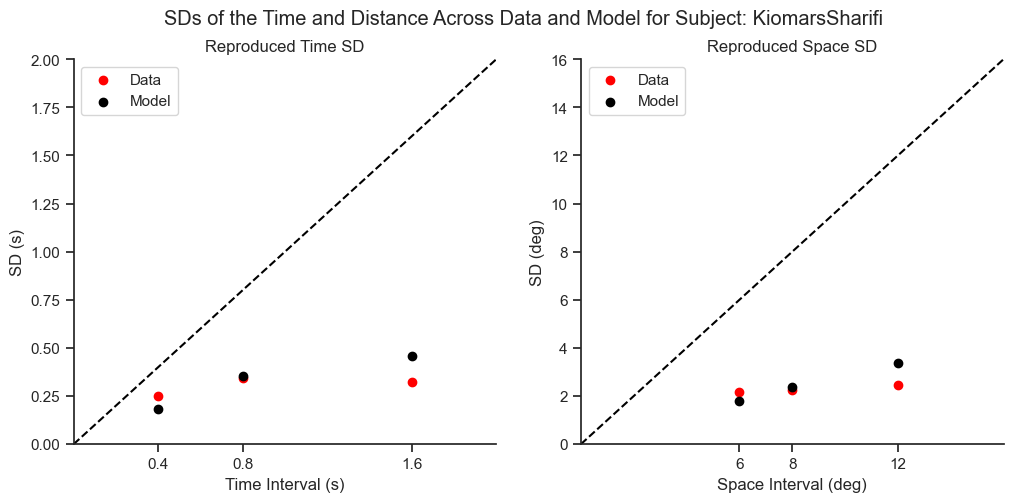

In [28]:
sns.set(style="ticks")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.despine()

vis.plotSdModelOverData(axs, 0, timeInts, siTime, siTimeTrans_BLS, 'Time', 's', [0, 2], [0, 2], 'red', 'black')
vis.plotSdModelOverData(axs, 1, distInts, siSpace, siSpaceTrans_BLS, 'Space', 'deg', [0, 16], [0, 16], 'red', 'black')
fig.suptitle(f'SDs of the Time and Distance Across Data and Model for Subject: {subjectName}')
fig.set_size_inches(12, 5)
# plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_SDs.png'), dpi=300)

# Save Parameters

In [62]:
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_BLS_Space'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_BLS_Space_Mod'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_MLE_Space'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_MLE_Space_Mod'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_BLS_Time'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_BLS_Time_Mod'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_MLE_Time'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_MLE_Time_Mod'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_BLS_Space'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_BLS_Space_Mod'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_MLE_Space'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_MLE_Space_Mod'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_BLS_Time'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_BLS_Time_Mod'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_MLE_Time'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_MLE_Time_Mod'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWm_BLS'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWm_BLS_Mod'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWm_MLE'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWm_MLE_Mod'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWp_BLS'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWp_BLS_Mod'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWp_MLE'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWp_MLE_Mod'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWm_BLS'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWm_BLS_Mod'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWm_MLE'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWm_MLE_Mod'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWp_BLS'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWp_BLS_Mod'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWp_MLE'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWp_MLE_Mod'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'timeAlpha_BLS'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceAlpha_BLS'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeAlpha_MLE'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceAlpha_MLE'] = float('nan')


for estim in estimType:
    if estim == 'BLS':
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWm_BLS'] = w_mTime_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWm_BLS_Mod'] = w_mTime_BLS_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWp_BLS'] = w_pTime_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWp_BLS_Mod'] = w_pTime_BLS_Mod

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWm_BLS'] = w_mSpace_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWm_BLS_Mod'] = w_mSpace_BLS_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWp_BLS'] = w_pSpace_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWp_BLS_Mod'] = w_pSpace_BLS_Mod
        
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_BLS_Time'] = AICTime_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_BLS_Time_Mod'] = AICTime_BLS_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_BLS_Time'] = BICTime_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_BLS_Time_Mod'] = BICTime_BLS_Mod

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_BLS_Space'] = AICSpace_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_BLS_Space_Mod'] = AICSpace_BLS_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_BLS_Space'] = BICSpace_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_BLS_Space_Mod'] = BICSpace_BLS_Mod

        subInfoInput.loc[subInfoInput['name'] == subjectName,'timeAlpha_BLS'] = facTime_BLS_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceAlpha_BLS'] = facSpace_BLS_Mod
    elif estim == 'MLE':
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWm_MLE'] = w_mTime_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWm_MLE_Mod'] = w_mTime_MLE_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWp_MLE'] = w_pTime_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWp_MLE_Mod'] = w_pTime_MLE_Mod

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWm_MLE'] = w_mSpace_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWm_MLE_Mod'] = w_mSpace_MLE_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWp_MLE'] = w_pSpace_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWp_MLE_Mod'] = w_pSpace_MLE_Mod
        
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_MLE_Time'] = AICTime_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_MLE_Time_Mod'] = AICTime_MLE_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_MLE_Time'] = BICTime_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_MLE_Time_Mod'] = BICTime_MLE_Mod

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_MLE_Space'] = AICSpace_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_MLE_Space_Mod'] = AICSpace_MLE_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_MLE_Space'] = BICSpace_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_MLE_Space_Mod'] = BICSpace_MLE_Mod

        subInfoInput.loc[subInfoInput['name'] == subjectName,'timeAlpha_MLE'] = facTime_MLE_Mod
        subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceAlpha_MLE'] = facSpace_MLE_Mod
        
subInfoInput.to_csv(os.path.join(subInfoPath, 'subInfo.csv'), index=False)


In [53]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
subInfoInput

,name,ID,age,gender,handedness,firstBlocks,lineLoc,lineOr,AIC_BLS_Space,AIC_BLS_Space_Mod,AIC_MLE_Space,AIC_MLE_Space_Mod,AIC_BLS_Time,AIC_BLS_Time_Mod,AIC_MLE_Time,AIC_MLE_Time_Mod,BIC_BLS_Space,BIC_BLS_Space_Mod,BIC_MLE_Space,BIC_MLE_Space_Mod,BIC_BLS_Time,BIC_BLS_Time_Mod,BIC_MLE_Time,BIC_MLE_Time_Mod,timeWm_BLS,timeWm_BLS_Mod,timeWm_MLE,timeWm_MLE_Mod,timeWp_BLS,timeWp_BLS_Mod,timeWp_MLE,timeWp_MLE_Mod,spaceWm_BLS,spaceWm_BLS_Mod,spaceWm_MLE,spaceWm_MLE_Mod,spaceWp_BLS,spaceWp_BLS_Mod,spaceWp_MLE,spaceWp_MLE_Mod,timeAlpha_BLS,spaceAlpha_BLS,timeAlpha_MLE,spaceAlpha_MLE
0,SepehrSima,1,23,M,R,time,right,up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MehdiSanayei,2,40,M,R,space,left,up,1787.866386,1769.858408,1779.176804,1758.691319,65.202291,44.338191,280.2686,250.265825,1795.893816,1781.899554,1787.204234,1770.732465,73.229722,56.379337,288.296031,262.306971,0.250836,0.282251,0.196456,0.274042,0.270235,0.272552,0.363986,0.274061,0.02598,0.02598,0.027337,0.22165,0.255606,0.236263,0.251881,0.073932,0.91972,1.05594,1.13764,1.10545
2,KiomarsSharifi,3,28,M,R,time,right,up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MobinAdli,4,23,M,R,space,right,up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AliHajian,5,21,M,L,time,left,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MiladYekani,6,35,M,R,space,left,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MobinaKhosravi,7,21,F,R,time,right,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SoodehMajidpour,8,34,F,R,space,right,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ParisaShadmehr,9,23,F,R,time,left,up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
subInfoPath  = r'F:\#2 MS Projects\Ongoing\timePerception\dataInfo\input'
subInfoInput = pd.read_csv(os.path.join(subInfoPath, 'subInfo.csv'))
subInfoInput = subInfoInput.loc[subInfoInput['name'] != 'KiomarsSharifi']
subInfoInput

,name,ID,age,gender,handedness,firstBlocks,lineLoc,lineOr,timeWm,timeWp,spaceWm_BLS,spaceWm_MAP,spaceWp_BLS,spaceWp_MAP,AIC_BLS_Space,AIC_MAP_Space,BIC_BLS_Space,BIC_MAP_Space
0,SepehrSima,1,23,M,R,time,right,up,0.337622,0.233568,0.028976,0.158092,0.249595,0.233362,1723.961549,1697.591458,1731.949471,1705.579381
1,MehdiSanayei,2,40,M,R,space,left,up,0.250867,0.270269,0.025980,0.001957,0.255601,0.254041,1787.866238,1779.493514,1795.893668,1787.520944
2,MobinAdli,4,23,M,R,space,right,up,0.428104,0.356516,0.059535,0.163463,0.256433,0.241339,1375.905159,1361.081314,1383.416643,1368.592798
3,AliHajian,5,21,M,L,time,left,down,0.188449,0.350713,0.026004,0.133796,0.217324,0.203603,1596.619869,1573.967595,1604.577640,1581.925367
4,MiladYekani,6,35,M,R,space,left,down,0.305341,0.267796,0.060327,0.049425,0.283220,0.288136,1787.226358,1793.718985,1795.153517,1801.646143
5,MobinaKhosravi,7,21,F,R,time,right,down,0.246262,0.314827,0.025980,0.146830,0.243093,0.228879,1729.349794,1704.295879,1737.362500,1712.308585
6,SoodehMajidpour,8,34,F,R,space,right,down,NaN,NaN,0.025980,0.129196,0.229740,0.218820,1693.720934,1673.038754,1701.748364,1681.066185
7,ParisaShadmehr,9,23,F,R,time,left,up,0.360200,0.488303,0.053203,0.116587,0.252453,0.244964,1737.312509,1730.046645,1745.290431,1738.024568


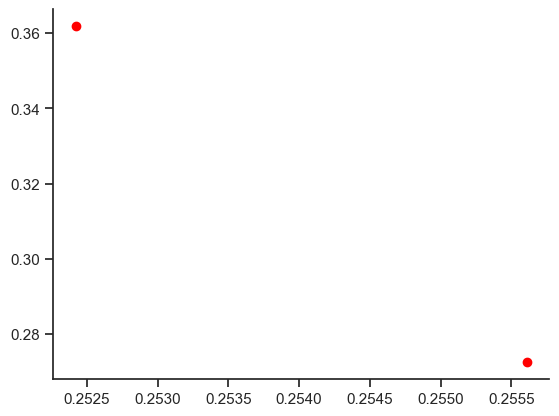

In [87]:
sns.set(style="ticks")
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))


# sns.lineplot(x=np.linspace(xLim[0], xLim[1], xLim[1]), y=np.linspace(yLim[0], yLim[1], yLim[1]), linestyle="dashed", color='black', ax=axs[axn])
# plt.scatter(x=subInfoInput['spaceWm_MAP'], y=subInfoInput['timeWm'], color='red')
plt.scatter(x=subInfoInput['spaceWp_BLS'], y=subInfoInput['timeWp_BLS_Mod'], color='red')
sns.despine()
# axs[axn].set_xlabel(f'{type} Interval ({unit})')
# axs[axn].set_ylabel(f'SD ({unit})')
# axs[axn].set_title(f'Reproduced {type} SD')
# axs[axn].set_xticks(Ints)
# axs[axn].set_xlim(xLim)
# axs[axn].set_ylim(yLim)
# axs[axn].legend([dat, mod], ['Data', 'Model'])

In [20]:
subInfoInput = subInfoInput.loc[subInfoInput['name'] != 'SoodehMajidpour']

r, p = pearsonr(subInfoInput['spaceWm_MAP'], subInfoInput['timeWm'])
r, p

(0.31691118535690166, 0.4885994980425767)